# Recurrent Neural Networks(RNN)

`-` RNN은 이전 시점의 정보들과 현 시점의 입력데이터의 정보를 이용하여 다음 시점의 값을 예측하는 것이다.

`-` RNN과 더불어 CNN은 텍스트와 주가 같은 시계열 데이터에 사용되나 CNN의 경우 순차적인 정보와 장기 의존성에 대한 문제 때문에 적합하지않다.

* 항상 그런 것은 아니지만 대부분 그럼(maxpooling만 생각해봐도 정보를 압축해서 대표값으로 feature를 표현하기 때문에 적합하지않음)

`-` 뭐 여튼, 결국 RNN은 이점시점의 정보들을 이용하여 다음 시점의 정보를 에측하는 것이다!

`-` RNN의 기본구조

$$h_t = \text {tanh}(w_{hh}h_{t-1} + W_{xh}x_t + b_h)$$

$$y_t  =  W_{hy}h_t + b_y$$

<center><img src="http://i.imgur.com/TIdBDTJ.png" width=600 title="source: imgur.com"></center>

## 실습 1. 주가 데이터

`-` 4주전의 온도 데이터를 가지고 그 다음주의 온도를 예측해보자.

### (1) 데이터 전처리

In [2]:
import pandas as pd

In [29]:
data = pd.read_csv('https://raw.githubusercontent.com/DA4BAM/dataset/master/temperature.csv')
data.head(10)

,year,week,AvgTemp
0,2010,1,-3.000000
1,2010,2,-7.500000
2,2010,3,-7.900000
3,2010,4,-2.357143
4,2010,5,-3.342857
5,2010,6,-1.800000
6,2010,7,-0.314286
7,2010,8,-2.142857
8,2010,9,4.400000
9,2010,10,7.057143


`-` y만들기

In [41]:
data["y"] = data["AvgTemp"].shift(-1)
data.dropna(axis = 0, inplace = True)

In [42]:
data.head()

,year,week,AvgTemp,y
0,2010,1,-3.000000,-7.500000
1,2010,2,-7.500000,-7.900000
2,2010,3,-7.900000,-2.357143
3,2010,4,-2.357143,-3.342857
4,2010,5,-3.342857,-1.800000


In [45]:
data.shape

(263, 4)

`-` x, y 분리

In [48]:
x = data.loc[:, ["AvgTemp"]]
y = data["y"]

`-` 스케일링

In [49]:
from sklearn.preprocessing import MinMaxScaler ## 텍스트 데이터에서는 다른 방법 사용

scaler = MinMaxScaler()
x = scaler.fit_transform(x)

`-` 3차원 구조 만들기

In [50]:
import numpy as np

In [51]:
# 시계열 데이터 전처리 2차원 --> 3차원으로 변환
def temporalize(x, y, timesteps):
    nfeature = x.shape[1]
    output_x = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        t = []
        for j in range(timesteps):
            t.append(x[[(i + j)], :])
        output_x.append(t)
        output_y.append(y[i + timesteps - 1])
    return np.array(output_x).reshape(-1,timesteps, nfeature), np.array(output_y)

In [52]:
x2, y2 =  temporalize(x, y, 4)
x2.shape, y2.shape

((260, 4, 1), (260,))

`-` 데이터셋 분할

In [53]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 53, shuffle = False) ## test_size를 53개로 지정

### (2) 모델링

In [56]:
x_train.shape[1], x_train.shape[]

(4, 1)

In [61]:
timestep = x_train.shape[1] ## 반영할 시점의 수
nf = x_train.shape[2] ##  feature

In [58]:
import tensorflow as tf

In [88]:
tf.keras.backend.clear_session()

X = tf.keras.layers.Input(shape = [timestep, nf])
hl = tf.keras.layers.SimpleRNN(8)(X)
Y = tf.keras.layers.Dense(1)(hl)

model = tf.keras.models.Model(X, Y)
model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(0.01))

In [89]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 1)]            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


`-` 은닉층 파라미터 개수 세보기 (hidden layer)

In [90]:
8*(8+1+1) ## (hidden output)x (hidden output + input feature + bias)

80

### (3) 모델 학습

In [91]:
history = model.fit(x_train, y_train, epochs = 100, validation_split = 0.2, verbose = 0).history

In [72]:
import matplotlib.pyplot as plt

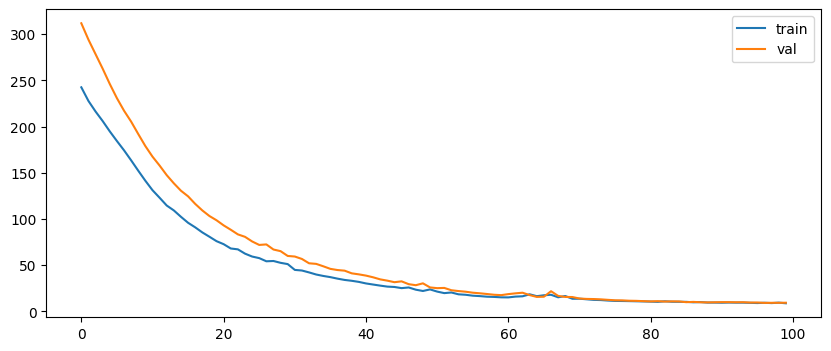

In [92]:
plt.figure(figsize = (10,4))
plt.plot(history["loss"], label = "train")
plt.plot(history["val_loss"], label = "val")
plt.legend()

### (4) 모델 예측

In [93]:
pred = model.predict(x_val)

2/2 [==============================] - 0s 10ms/step


In [94]:
from sklearn.metrics import *

mean_absolute_error(y_val, pred)

2.579951970680879

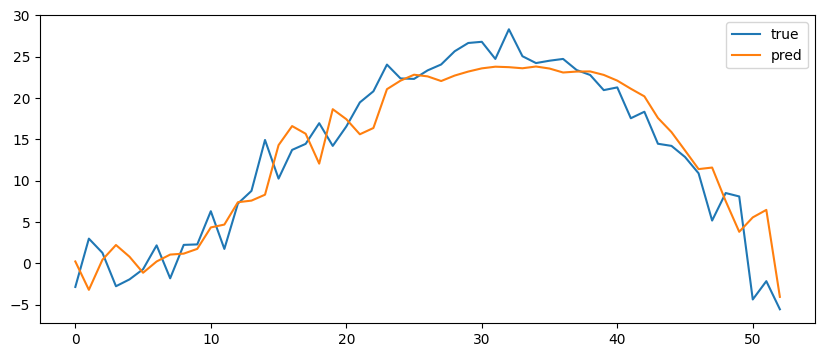

In [95]:
plt.figure(figsize = (10,4))
plt.plot(y_val, label = "true")
plt.plot(pred, label = "pred")
plt.legend()

`-` 오 너무나도 잘 적합되었음.

## 실습 2. 주가 데이터 (RNN layer 2개)

In [100]:
from tensorflow.keras.backend import clear_session
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [117]:
clear_session()

X = layers.Input(shape = [timestep, nf])

h1 = layers.SimpleRNN(8, return_sequences = True)(X)
h2 = layers.SimpleRNN(4)(h1)

Y = layers.Dense(1)(h2)

model = Model(X, Y)
model.compile(loss = "mse", optimizer = Adam(0.01))

In [118]:
h = model.fit(x_train, y_train, validation_split = 0.2, epochs = 100,
                        verbose = 0).history

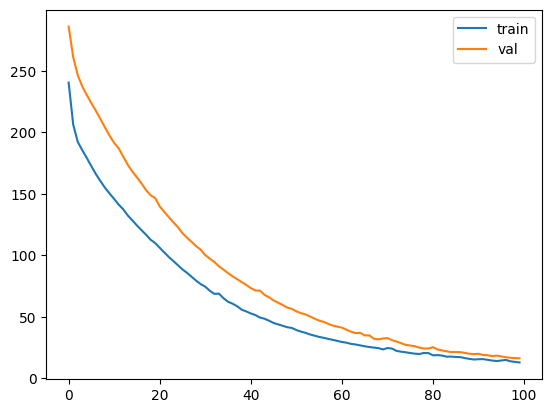

In [119]:
plt.plot(h["loss"], label = "train")
plt.plot(h["val_loss"], label = "val")
plt.legend()

In [120]:
pred = model.predict(x_val)

2/2 [==============================] - 0s 6ms/step


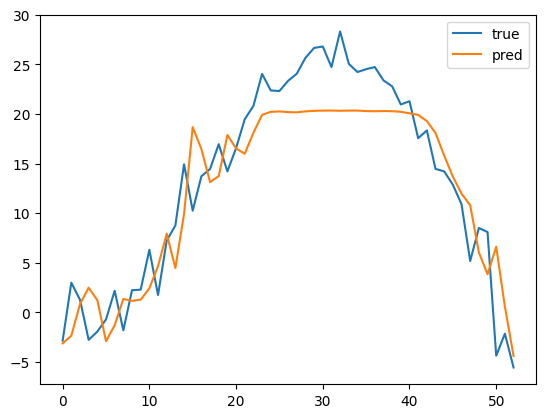

In [124]:
plt.plot(y_val, label = "true")
plt.plot(pred, label = "pred")
plt.legend()

`-` 특정 구간에서 처음에 설정한 모델보다 잘 예측하지 못함..

* 어떻게 보면 당연한 거임. RNN layer의 각 은닉 노드는 이전 시점의 값을 계속 반영하는데 당연히 2개나 쌓으니 overfitting이 날 수 빆에 없음..

***

## 실습 3.  IMDB 영화 리뷰 데이터

### (1) 데이터 로드 및 이해

In [125]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

17464789/17464789 [==============================] - 0s 0us/step


In [126]:
print(x_train.shape, y_train.shape)

(25000,) (25000,)


`-` 이미 주어진 데이터는 인코딩 되어 있음

In [128]:
print(x_train[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


`-` 각 target 변수들은 동일한 비율로 구성되어 있음.

In [131]:
np.unique(y_train,return_counts=True)

(array([0, 1]), array([12500, 12500]))

`-` padding

In [140]:
x_train  = tf.keras.utils.pad_sequences(x_train, maxlen = 20)
x_test  = tf.keras.utils.pad_sequences(x_test, maxlen = 20)

print(x_train.shape, x_test.shape)

(25000, 20) (25000, 20)


### (2) 모델링

#### tpu 셋팅

In [156]:
import tensorflow as tf
import os

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

In [158]:
strategy = tf.distribute.TPUStrategy(resolver)

In [181]:
layers.Embedding?

In [196]:
clear_session()
with strategy.scope() :
          X = layers.Input(shape = [20]) ## max_len = 20 이므로
          H = layers.Embedding(input_dim = 88585, output_dim = 10, input_length = 20)(X) ## 총 단어개수 88585, 28은
          H = layers.SimpleRNN(32)(H)
          Y =  layers.Dense(1, activation = "sigmoid")(H)

          model = Model(X,Y)
          model.compile(loss = tf.keras.losses.binary_crossentropy,
                                      optimizer = Adam(0.01))

In [197]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20)]              0         
                                                                 
 embedding (Embedding)       (None, 20, 10)            885850    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1376      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 887,259
Trainable params: 887,259
Non-trainable params: 0
_________________________________________________________________


`-` 임베딩 레이어 파라미터 수

In [200]:
88585 * 10

885850

`-` rnn 레이어 파라미터 수

* 앞서 배운 시계열 데이터라고 생각하면, 20일치 데이터를 28개의 차원으로 전달해서 32개의 은닉노드를 가지는 RNN레이어에 태운 것임

In [201]:
(10+32+1)*32

430

### (3) 모델 학습

In [202]:
h = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2,
                verbose = 1).history

Epoch 1/10
625/625 [==============================] - 16s 21ms/step - loss: 0.6116 - val_loss: 0.5674
Epoch 2/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4921 - val_loss: 0.6649
Epoch 3/10
625/625 [==============================] - 11s 18ms/step - loss: 0.5216 - val_loss: 0.6466
Epoch 4/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4466 - val_loss: 0.6317
Epoch 5/10
625/625 [==============================] - 10s 16ms/step - loss: 0.4363 - val_loss: 0.6761
Epoch 6/10
625/625 [==============================] - 11s 18ms/step - loss: 0.4677 - val_loss: 0.6652
Epoch 7/10
625/625 [==============================] - 10s 17ms/step - loss: 0.4385 - val_loss: 0.6793
Epoch 8/10
625/625 [==============================] - 10s 15ms/step - loss: 0.4090 - val_loss: 0.6845
Epoch 9/10
625/625 [==============================] - 12s 19ms/step - loss: 0.4148 - val_loss: 0.6996
Epoch 10/10
625/625 [==============================] - 11s 17ms/step - loss: 0.481

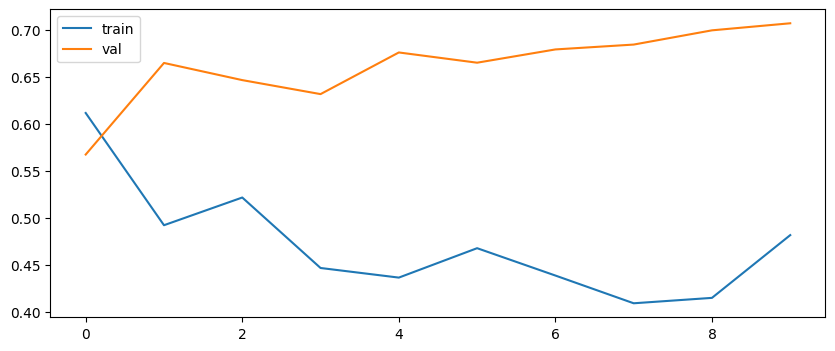

In [203]:
plt.figure(figsize = (10, 4))
plt.plot(h["loss"], label = "train")
plt.plot(h["val_loss"], label = "val")
plt.legend()
plt.show()

### (4) 예측

In [204]:
pred = model.predict(x_test)

782/782 [==============================] - 10s 11ms/step


`-` 흠 모델 성능이 쓰레기다..

### (5) 배치정규화 추가

In [235]:
clear_session()
with strategy.scope() :
          X = layers.Input(shape = [20]) ## max_len = 20 이므로
          H = layers.Embedding(input_dim = 88585, output_dim = 10, input_length = 20)(X) ## 총 단어개수 88585, 28은
          H = layers.SimpleRNN(32)(H)
          H = layers.BatchNormalization()(H)
          Y =  layers.Dense(1, activation = "sigmoid")(H)

          model = Model(X,Y)
          model.compile(loss = tf.keras.losses.binary_crossentropy,
                                      optimizer = Adam(0.001))

In [236]:
h = model.fit(x_train, y_train, epochs = 10, validation_split = 0.2,
                verbose = 1).history

Epoch 1/10
625/625 [==============================] - 16s 19ms/step - loss: 0.6240 - val_loss: 0.5372
Epoch 2/10
625/625 [==============================] - 10s 16ms/step - loss: 0.4808 - val_loss: 0.7613
Epoch 3/10
625/625 [==============================] - 11s 17ms/step - loss: 0.3965 - val_loss: 0.5965
Epoch 4/10
625/625 [==============================] - 10s 16ms/step - loss: 0.3379 - val_loss: 1.9309
Epoch 5/10
625/625 [==============================] - 10s 17ms/step - loss: 0.3052 - val_loss: 0.9143
Epoch 6/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2626 - val_loss: 0.8126
Epoch 7/10
625/625 [==============================] - 11s 17ms/step - loss: 0.2518 - val_loss: 1.0190
Epoch 8/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2296 - val_loss: 1.2424
Epoch 9/10
625/625 [==============================] - 10s 16ms/step - loss: 0.2284 - val_loss: 0.8976
Epoch 10/10
625/625 [==============================] - 10s 16ms/step - loss: 0.215

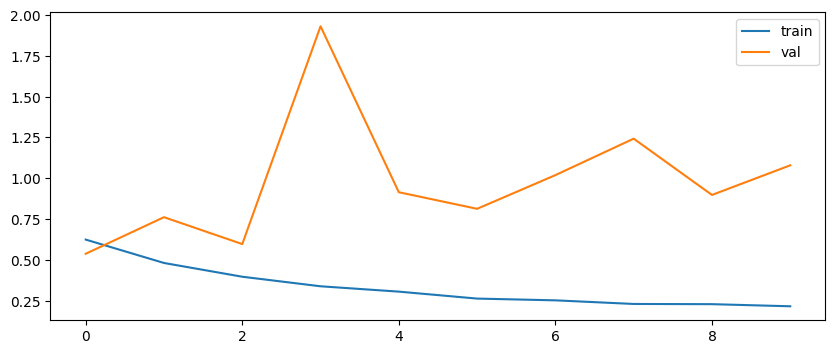

In [237]:
plt.figure(figsize = (10, 4))
plt.plot(h["loss"], label = "train")
plt.plot(h["val_loss"], label = "val")
plt.legend()
plt.show()

In [238]:
pred = model.predict(x_test)
pred

782/782 [==============================] - 14s 14ms/step


array([[0.973527  ],
       [0.9925418 ],
       [0.91735345],
       ...,
       [0.41336167],
       [0.5320429 ],
       [0.9485291 ]], dtype=float32)

In [239]:
y_pred = np.where(pred>=0.5,1,0)

In [241]:
print(confusion_matrix(y_test,y_pred))

[[ 7156  5344]
 [ 1969 10531]]


`-` 성능이 그닥.....

In [242]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66     12500
           1       0.66      0.84      0.74     12500

    accuracy                           0.71     25000
   macro avg       0.72      0.71      0.70     25000
weighted avg       0.72      0.71      0.70     25000



***

## summary

`-` RNN 모델은 시계열, 텍스트 데이터와 같이 시간의 흐름에 따른 시퀀셜 데이터에 대한 모형 적합시 사용된다.

`-` 그러나 앞서 살펴보았듯이 높은 예측성을 기대하는 것은 좀 힘듬...

`-` 그래디언트 소실문제

*  긴 시퀀스를 처리할 때 발생

* 역전파 시에 gradient가 작아져 학습이 어려워지는 현상

* tanh함수는 비선형성을 유지시켜주면서, 시그모이드에 비해 gradient를 더 크게 유지시켜주나 그래도 기울기 소실문제를 완전히 해결한 것이 아님

*  이러한 그래디언트 소실 문제를 장기 의존성 문제라고 하며 LSTM에서 이를 어느정도 해결하는 법을 배운다!

## ref

[ratsgo's NLPBOOK](https://ratsgo.github.io/nlpbook/) : Copyright © 2020 Gichang LEE.